In [163]:
import numpy as np
import cvxopt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

Исходная задача эквивалентна задаче квадратичного программирования:

$ \frac{1}{2} x^T P x + q^T x \rightarrow \min\limits_{x}$

$G x \le h$

$A x = b$

Можно показать, что веса и смещение находятся из соотношений:

$w = \sum\limits_{i=1}^n \lambda_i c_i x_i$

$b = w x_i - c_i$

Где $\lambda$ - решение задачи квадратичного программирования:

$1^T \lambda - \frac{1}{2}\lambda^T X^T X \lambda \rightarrow \max\limits_{\lambda}$

$\lambda \ge 0$

$y^T \lambda = 0$

А метка класса определяется из соотношения:

$c(x) = sign(w \cdot x - b)$

В терминах каноничесной постановки задачи квадратичного программирования имеем:

$P = X^T X, \thinspace \thinspace \thinspace X = [x_1 y_1, x_2 y_2, \cdots x_n y_n]$

$q = [-1, -1, -1, \cdots -1] $

$A = y^T$

$b = 0$

$G = diag(-1)$

$h = [0, 0, 0, \cdots 0]$

In [150]:
class SVM:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.dot(X[i], X[j])
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h = cvxopt.matrix(np.zeros(n_samples))
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
# Множители Лагранжа
        a = np.ravel(solution['x'])
# Интересуют только больше 0
        sv = a > 1e-5 # ошибки округления
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
# константа b для модели SVM
        self.b = np.sum(self.sv_y)
        for n in range(len(self.a)):
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
        self.b /= len(self.a)
# W веса для модели SVM
        self.w = np.zeros(n_features)
        for n in range(len(self.a)):
            self.w += self.a[n] * self.sv_y[n] * self.sv[n]
   
    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

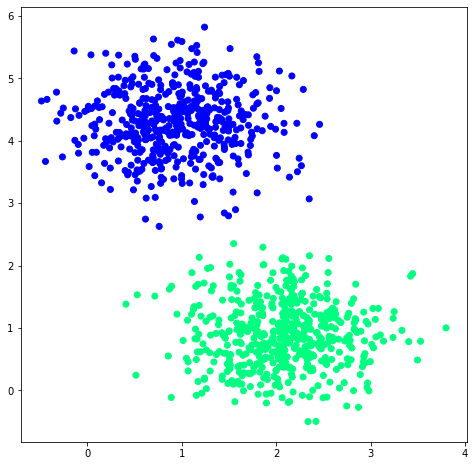

In [159]:
X, y = make_blobs(n_samples=1000, centers=2,
                  random_state=0, cluster_std=0.55)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y
plt.figure(figsize=[8,8])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')
plt.show()

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [161]:
svm = SVM()
svm.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -6.1317e+01 -1.1745e+02  2e+03  4e+01  2e+00
 1: -7.4324e+01 -5.8314e+01  1e+03  2e+01  8e-01
 2: -1.2902e+02 -9.8661e+01  1e+03  2e+01  8e-01
 3: -3.4876e+02 -2.6058e+02  1e+03  2e+01  7e-01
 4: -9.2909e+02 -6.2978e+02  1e+03  2e+01  7e-01
 5: -4.1622e+02 -1.5364e+02  1e+03  8e+00  3e-01
 6: -7.2010e+01 -1.6906e+01  1e+02  1e+00  4e-02
 7: -2.7878e+01 -1.3450e+01  5e+01  3e-01  1e-02
 8: -6.6641e+00 -1.1450e+01  2e+01  9e-02  4e-03
 9: -9.3718e+00 -9.9361e+00  2e+00  8e-03  3e-04
10: -9.9144e+00 -9.9204e+00  2e-02  8e-05  4e-06
11: -9.9202e+00 -9.9202e+00  2e-04  8e-07  4e-08
12: -9.9202e+00 -9.9202e+00  2e-06  8e-09  4e-10
Optimal solution found.


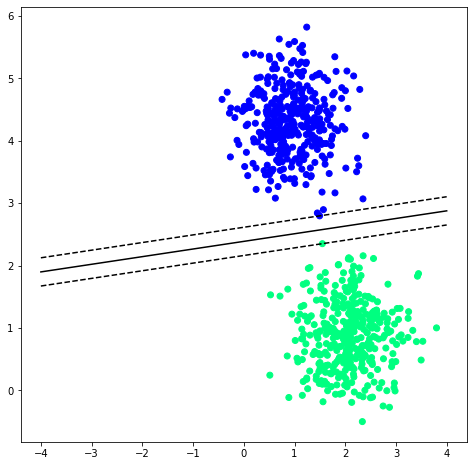

In [157]:
def f(x, w, b, c=0):
    return (-w[0] * x - b + c) / w[1]
plt.figure(figsize=[8,8])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')
# w.x + b = 0
a0 = -4; a1 = f(a0, svm.w, svm.b)
b0 = 4; b1 = f(b0, svm.w, svm.b)
plt.plot([a0,b0], [a1,b1], 'k')
# w.x + b = 1
a0 = -4; a1 = f(a0, svm.w, svm.b, 1)
b0 = 4; b1 = f(b0, svm.w, svm.b, 1)
plt.plot([a0,b0], [a1,b1], 'k--')
# w.x + b = -1
a0 = -4; a1 = f(a0, svm.w, svm.b, -1)
b0 = 4; b1 = f(b0, svm.w, svm.b, -1)
plt.plot([a0,b0], [a1,b1], 'k--')
plt.show()

In [166]:
y_pred = svm.predict(X_test)
print('{} %'.format(accuracy_score(y_test, y_pred) * 100))

100.0 %


# Сравнение с sklearn

100.0 %


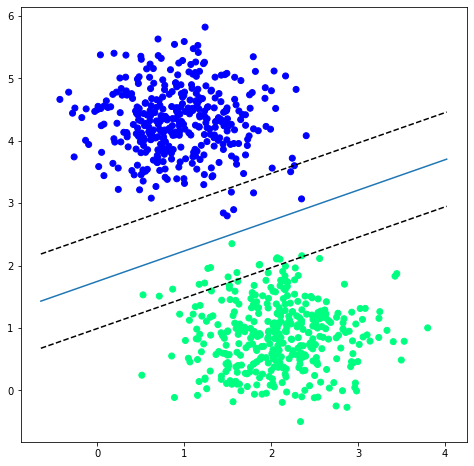

In [169]:
svc = LinearSVC()
svc.fit(X_train, y_train)
plt.figure(figsize=[8,8])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter');
ax = plt.gca()
xlim = ax.get_xlim()
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - svc.intercept_[0] / w[1]
plt.plot(xx, yy)
yy = a * xx - (svc.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
yy = a * xx - (svc.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')

y_pred = svc.predict(X_test)
print('{} %'.format(accuracy_score(y_test, y_pred) * 100))